# Hashtags

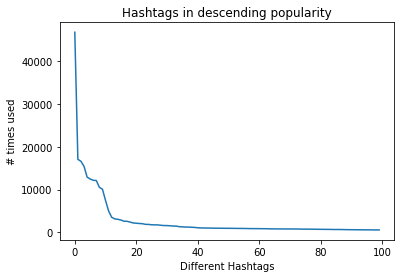

In [1]:
import json
import os.path
import pickle 
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline  

hashtag_cnt = Counter()
tag_counter = 0

if not os.path.exists('hashtag_cnt.pkl'):
    with open('full.json', 'r') as tweets_file:   # EDIT FILENAME
        for idx, line in enumerate(tweets_file):
            try:
                tweet = json.loads(line)
                hash_tags  = tweet['entities']['hashtags']
                for tag in hash_tags:
                    tag_counter += 1
                    text = tag['text']
                    hashtag_cnt[text] += 1

                if idx % 10000 == 0:
                    print(idx)

            except Exception as e:
                print (e)
                continue

        # Dump the graph in a pickle file so we don't have
        # to run this 1 minute process often.
        pickle.dump(hashtag_cnt, open('hashtag_cnt.pkl', 'wb'))

# Plot the 100 most popular tweets to see their popularity distribution.
hashtag_cnt = pickle.load(open('hashtag_cnt.pkl', 'rb'))
total_nr_hashtags = sum(hashtag_cnt.values())
tag_popularities = sorted(hashtag_cnt.values(),reverse=True)
plt.plot(tag_popularities[:100])
plt.title('Hashtags in descending popularity')
plt.xlabel('Different Hashtags')
plt.ylabel('# times used')
plt.show()

## Wait... Is that a power law distribution?

A powerlow distribution can be linearized (straightened) with a log-log graph.

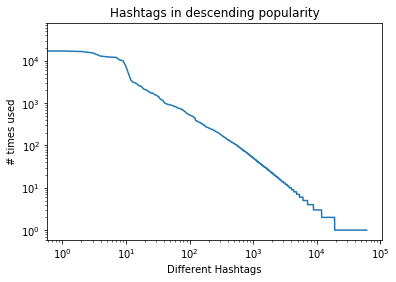

In [2]:
plt.loglog(tag_popularities)
plt.title('Hashtags in descending popularity')
plt.xlabel('Different Hashtags')
plt.ylabel('# times used')
plt.show()

### Yes it is! The plot is straightened when plotted on loglog axis. 

## Some general statistics

In [3]:
print(hashtag_cnt.most_common(10))
top_ten = sum(tag_popularities[:10])
top_hundred = sum(tag_popularities[:100])
top_five_hundred = sum(tag_popularities[:500])

percentage_ten = (top_ten / total_nr_hashtags) * 100
precentage_hundred = (top_hundred / total_nr_hashtags) * 100
precentage_five_hundred = (top_five_hundred / total_nr_hashtags) * 100

print('\n\nThe first 10 hashtags account for {:.2f}% of all hashtags used:'.format(percentage_ten))
print('The first 100 hashtags account for {:.2f}% '.format(precentage_hundred))
print('The first 500 hashtags account for {:.2f}%'.format(precentage_five_hundred))


[('Trump', 46847), ('MAGA', 17067), ('NeverTrump', 16615), ('ImWithHer', 15426), ('TrumpPence16', 12924), ('Hillary', 12456), ('HillaryClinton', 12161), ('NeverHillary', 12099), ('DonaldTrump', 10505), ('CrookedHillary', 10061)]


The first 10 hashtags account for 29.95% of all hashtags used:
The first 100 hashtags account for 49.94% 
The first 500 hashtags account for 65.54%


# Hashtag Coocurrence

# Expanding The Sentiment Hashtags Set
Out of the top 100, a few tags were chosen that clearly had pro or anti candidate sentiment. A few examples are #NeverTrump, #LockHerUp or #ImWithHer. 

We can expand this list by looking at other hashtags that appear in the same tweets. If these tags appear > 95% of the time in one camp, we add them to that camp 

The could also possible solve our skewing problem, where most of these tags tend to be pro Trump. 

In [4]:
trump_team_tags = set(['MAGA','TrumpPence16','TrumpTrain','trumptrain','MakeAmericaGreatAgain','NEVERHILLARY','StopHillary','neverhillary','LockHerUp','TrumpPence2016','NoMoreClintons','Hillary4Prison','CrookedHillary','crookedhillary','NeverHillary','LockHerUp','TrumpsArmy','VoteTrump','maga','Trump2016','StopHillary','VOTEGOP'])
hillary_team_tags = set(['NeverTrump','ImWithHer','DumpTrump','FuckYouDonald','imwithher','Hillary2016','neverTrump','VoteBlue','dumptrump','UniteBlue','nevertrump','DonTheCon'])
both_camps = trump_team_tags.union(hillary_team_tags)

sentiment_hashtags_nr = 0
count_hillary = 0
count_trump = 0

for tag in hillary_team_tags: 
    sentiment_hashtags_nr += hashtag_cnt[tag]
    count_hillary += hashtag_cnt[tag]
    
for tag in trump_team_tags: 
    sentiment_hashtags_nr += hashtag_cnt[tag]
    count_trump += hashtag_cnt[tag]

nr_trump = len(trump_team_tags)
nr_hillary = len(hillary_team_tags)
total_count = count_trump + count_hillary
percent_hillary = (count_hillary / total_count) * 100 
percent_trump  = (count_trump / total_count) * 100 

print('With our semtiment list, we cover {:.2f}% of all hashtags used'.format((
      sentiment_hashtags_nr / total_nr_hashtags) * 100))

print('\nThere is quite a large skew in sentiment hashtags')
print('{} Trump tags and {} Hillary tags'.format(nr_trump, nr_hillary))
print('Their counts add up to {} Trump and {} Hillary'.format(count_trump, count_hillary))
print('That is {:.2f}% Trump and {:.2f}% Hillary'.format(percent_trump, percent_hillary))

With our semtiment list, we cover 21.91% of all hashtags used

There is quite a large skew in sentiment hashtags
20 Trump tags and 12 Hillary tags
Their counts add up to 74321 Trump and 47221 Hillary
That is 61.15% Trump and 38.85% Hillary


In [5]:
import itertools

cooccur_dict = dict()

for tag in both_camps:
    cooccur_dict[tag] = Counter()
    
if not os.path.exists('cooccur.pkl'):
    with open('full.json', 'r') as tweets_file:   # EDIT FILENAME
        for idx, line in enumerate(tweets_file):
            try:
                if idx % 10000 == 0:
                    print(idx)

                tweet = json.loads(line)
                hash_tags  = tweet['entities']['hashtags']

                all_tags = set()
                for tag in hash_tags:
                    tag_text = tag['text']
                    all_tags.add(tag_text)

                if both_camps.intersection(all_tags): # If any tags appear in the camps
                    for combi in itertools.combinations(all_tags, 2):
                        (first, second) = combi
                        # Not efficient but will have to do for now
                        if first in both_camps and second in both_camps:
                            continue
                        if first in both_camps:
                            cooccur_dict[first][second] += 1

                        if second in both_camps:
                            cooccur_dict[second][first] += 1

            except Exception as e:
                print(e)
                continue
    pickle.dump(cooccur_dict, open('cooccur.pkl', 'wb'))

cooccur_dict = pickle.load(open('cooccur.pkl', 'rb'))

In [6]:
from pprint import pprint 
for val in cooccur_dict:
    print(val)
print(len(cooccur_dict))


ImWithHer
TrumpsArmy
LockHerUp
MAGA
StopHillary
VOTEGOP
Trump2016
VoteBlue
TrumpTrain
TrumpPence2016
DonTheCon
TrumpPence16
DumpTrump
NeverHillary
neverhillary
MakeAmericaGreatAgain
trumptrain
neverTrump
NoMoreClintons
crookedhillary
CrookedHillary
VoteTrump
NeverTrump
FuckYouDonald
Hillary2016
dumptrump
imwithher
nevertrump
NEVERHILLARY
Hillary4Prison
UniteBlue
maga
32


In [7]:

trump_tag_cnt = Counter()
hillary_tag_cnt = Counter()

for tag in hillary_team_tags:
    for coocur_tag in cooccur_dict[tag]:
        hillary_tag_cnt[coocur_tag] += cooccur_dict[tag][coocur_tag]
            
for tag in trump_team_tags:
    for coocur_tag in cooccur_dict[tag]:
        trump_tag_cnt[coocur_tag] += cooccur_dict[tag][coocur_tag]

# Add new tags to Trump team 
for tag in trump_tag_cnt: 
    total_appears = trump_tag_cnt[tag] + hillary_tag_cnt[tag]
    # If > 90% of the appearances are in a team
    # Assign it to that team
    if trump_tag_cnt[tag] > (0.99 * total_appears) and total_appears > 10: 
        trump_team_tags.add(tag)

# Add new tags to Hillary team
for tag in hillary_tag_cnt: 
    total_appears = trump_tag_cnt[tag] + hillary_tag_cnt[tag]
    if hillary_tag_cnt[tag] > (0.99 * total_appears) and total_appears > 10: 
        hillary_team_tags.add(tag)

In [8]:
both_camps = trump_team_tags.union(hillary_team_tags)

sentiment_hashtags_nr = 0
count_hillary = 0
count_trump = 0


for tag in trump_team_tags: 
    sentiment_hashtags_nr += hashtag_cnt[tag]
    count_trump += hashtag_cnt[tag]
    

for tag in hillary_team_tags: 
    sentiment_hashtags_nr += hashtag_cnt[tag]
    count_hillary += hashtag_cnt[tag]


nr_trump = len(trump_team_tags)
nr_hillary = len(hillary_team_tags)
total_count = count_trump + count_hillary
percent_hillary = (count_hillary / total_count) * 100 
percent_trump  = (count_trump / total_count) * 100 

print('With our semtiment list, we cover {:.2f}% of all hashtags used'.format((
      sentiment_hashtags_nr / total_nr_hashtags) * 100))

print('\nThere is quite a large skew in sentiment hashtags')
print('{} Trump tags and {} Hillary tags'.format(nr_trump, nr_hillary))
print('Their counts add up to {} Trump and {} Hillary'.format(count_trump, count_hillary))
print('That is {:.2f}% Trump and {:.2f}% Hillary'.format(percent_trump, percent_hillary))

With our semtiment list, we cover 27.54% of all hashtags used

There is quite a large skew in sentiment hashtags
417 Trump tags and 214 Hillary tags
Their counts add up to 96994 Trump and 55802 Hillary
That is 63.48% Trump and 36.52% Hillary


In [41]:
import random 

print('let us take a look at some of the new tags')
orig_trump_team_tags = set(['MAGA','TrumpPence16','TrumpTrain','trumptrain','MakeAmericaGreatAgain','NEVERHILLARY','StopHillary','neverhillary','LockHerUp','TrumpPence2016','NoMoreClintons','Hillary4Prison','CrookedHillary','crookedhillary','NeverHillary','LockHerUp','TrumpsArmy','VoteTrump','maga','Trump2016','StopHillary','VOTEGOP'])
orig_hillary_team_tags = set(['NeverTrump','ImWithHer','DumpTrump','FuckYouDonald','imwithher','Hillary2016','neverTrump','VoteBlue','dumptrump','UniteBlue','nevertrump','DonTheCon'])

new_trump_tags = random.sample(trump_team_tags - orig_trump_team_tags, 10)
new_hillary_tags = random.sample(hillary_team_tags - orig_hillary_team_tags, 10)

print('New Pro Trump tags ', new_trump_tags)
print('New Pro Hillary tags ', new_hillary_tags)

let us take a look at some of the new tags
New Pro Trump tags  ['illaryclinton', 'TRUMPPENCE', 'IDontRecall', 'BigData', 'TrumpinDetroit', 'VeteransForTrump', 'CrookedClintons', 'silentmajority', 'clintonOrganizedCrime', 'VETERANSFORTRUMP']
New Pro Hillary tags  ['pinko', 'WomensRights', 'Diversity', 'PETA', 'EqualPay', 'TurnSenateBlue', 'ClintonKaineLibertyAndJustice2016', 'Vote4Hillary', 'MDforHRC', 'trumpfreezone']


In [39]:
print(len(trump_team_tags))
print(len(hillary_team_tags))

417
214


In [11]:
import networkx as nx
import itertools

G = nx.Graph(name='Hashtags')
if not os.path.exists('graph.pkl'):
    with open('full.json', 'r') as tweets_file:   # EDIT FILENAME
        for idx, line in enumerate(tweets_file):
            try:
                if idx % 10000 == 0:
                    print(idx)
                tweet = json.loads(line)
                hash_tags  = tweet['entities']['hashtags']

                all_tags = set()
                for tag in hash_tags:
                    tag_text = tag['text']
                    all_tags.add(tag_text)

                    if tag_text not in G:
                        G.add_node(tag_text, node_size=0)
                    G.node[tag_text]['node_size'] += 1

                # Go through each hashtag pair and create edges
                for combi in itertools.combinations(all_tags, 2):
                    if combi not in G.edges:
                        (first, second) = combi
                        G.add_edge(first, second, weight = 0, color='black')
                    G.edges[combi]['weight'] += 1

            except Exception as e:
                print(e)
                continue

    pickle.dump(G, open('graph.pkl', 'wb'))

G = pickle.load(open('graph.pkl', 'rb'))

print('Some general information about this graph')
print(nx.info(G))

Some general information about this graph
Name: 
Type: Graph
Number of nodes: 60821
Number of edges: 269476
Average degree:   8.8613


# Filtering Out Hashtags With Low Count

In [12]:
original_node_count = G.number_of_nodes()
original_edge_count = G.number_of_edges()

### Threshold on node size
to_remove = []
for node in G.nodes:
    if G.nodes[node]['node_size'] < 600:
        to_remove.append(node)

for node in to_remove:
    G.remove_node(node)

node_count = G.number_of_nodes()
edge_count = G.number_of_edges()

print('What\'s left?')
print('Number of nodes: {}'.format(node_count))
print('Number of edges: {}\n\n'.format(edge_count))

print('That is {:.2f}% of the original hashtags'.format((node_count/original_node_count)*100))
print('That is {:.2f}% percent of the original edges'.format((edge_count/original_edge_count)*100))


What's left?
Number of nodes: 88
Number of edges: 2518


That is 0.14% of the original hashtags
That is 0.93% percent of the original edges


# Detecting Communities
#### run `pip install python-louvain` to install the community detection algorithm

In [13]:
import community

# Detect communities
parts = community.best_partition(G)
classes = [parts.get(node) for node in G.nodes()]

nr_classes = len(set(classes))
print('The following classes were found:', set(classes))
print('Which is {} classes'.format(nr_classes))

The following classes were found: {0, 1, 2, 3, 4, 5}
Which is 6 classes


# Drawing That Graph

### Preparation

In [34]:
# give edges between same class the same color
edge_colors = []
edge_to_remove = []

yellow = '#ffe119'
orange = '#f58231'
red = '#e6194B'
green = '#3cb44b'
blue = '#4363d8'
purple = '#911eb4'
brown = '#9A6324'
grey = '#ebebeb'

colors = [yellow, orange, red, green, blue, purple, brown]

for edge in G.edges:
    (first, second) = edge
    if parts.get(first) == parts.get(second):
        this_class = parts.get(first)
        # The color index is the class label
        edge_colors.append(colors[this_class])
    else:
        edge_colors.append(grey)
        
node_colors = [colors[parts.get(node)] for node in G.nodes()]

# Create network layout for visualizations
# We will use the Fruchterman-Reingold force-directed
# algorithm, a.k.a. the spring layout. 
spring_pos = nx.spring_layout(G, k=3.5, iterations=50)

### Drawing

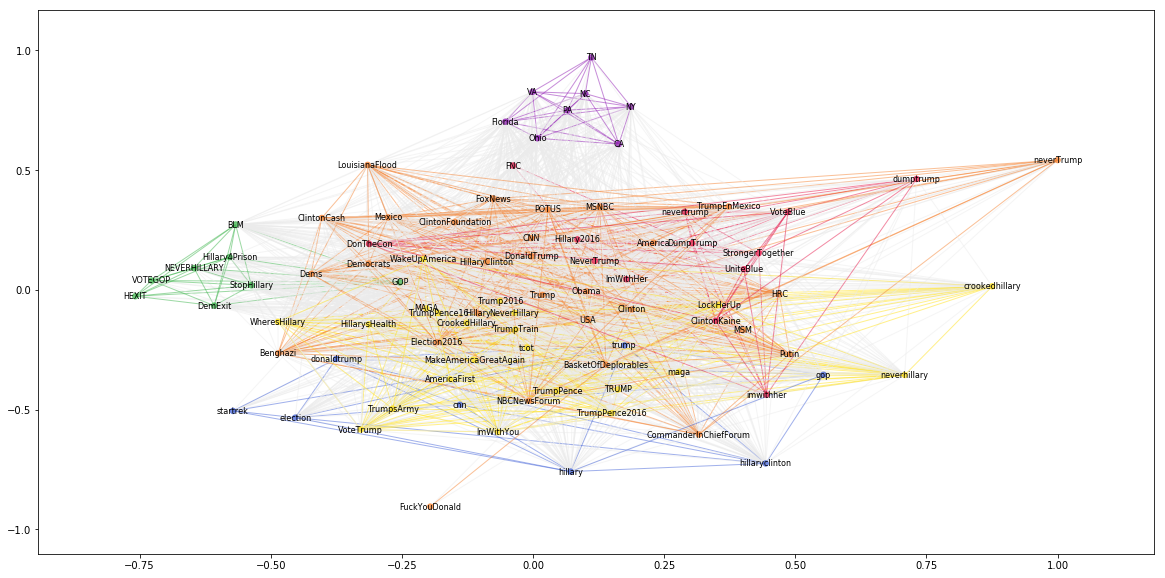

In [35]:
# Increase the figure size
plt.rcParams['figure.figsize'] = (20.0, 10.0)

nx.draw_networkx_nodes(G, pos=spring_pos, node_color=node_colors, node_size=30, alpha=0.7)

nx.draw_networkx_edges(G, pos=spring_pos, edge_color=edge_colors, alpha=0.5)

nx.draw_networkx_labels(G, pos=spring_pos, font_size=8)

# Save the plot for later viewing
plt.savefig('filename.png', dpi = 300)

# Plot the plot too
plt.show()

# Pruning the graph
As can be seen from the plotted graph, there are many connections running inbetween classes (grey lines). This means that the hashtags 'Ohio' and 'Florida' have appear in combination with hashtags in classes that have nothing to do with location. We only know that the hashtags in a single class are meaningfully connected: they are connected enough to pass as a single class.
   
What can we gain from removing insignificant edges? This process is called pruning and can be doneby simple thresholding or by more sophisticated means. Here we will apply backbone extract. A method described in the paper ['Extracting the multiscale backbone of complex weighted networks'](http://www.pnas.org/content/106/16/6483)
   
To run this code, [this repository](https://github.com/aekpalakorn/python-backbone-network) has to be included in the directory.

original: nodes = 88, edges = 2518
backbone: nodes = 85, edges = 289


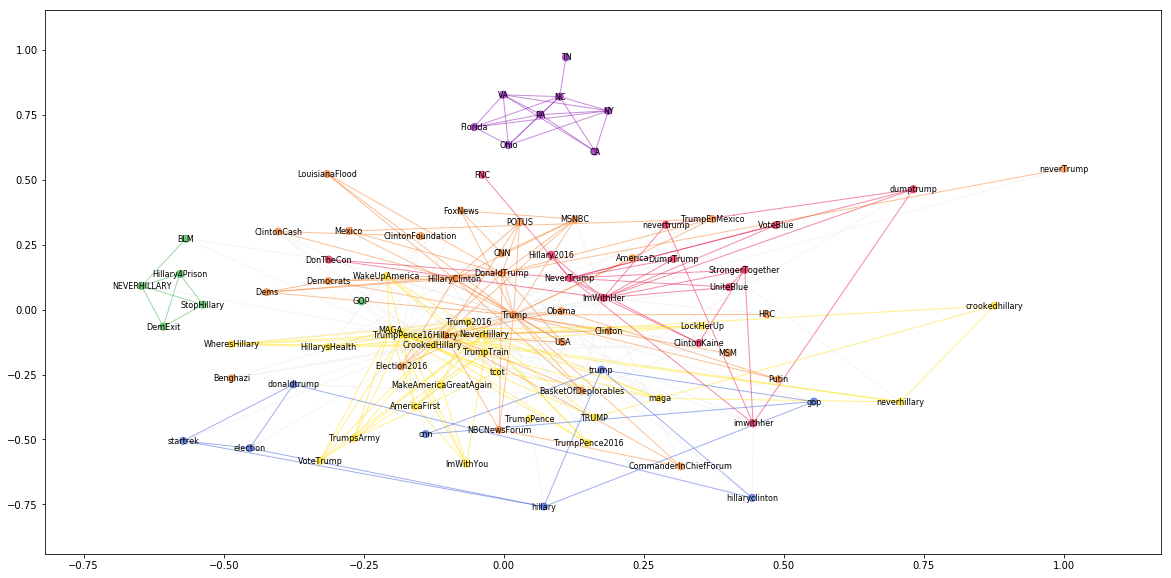

In [36]:
from backbone import disparity_filter

G = disparity_filter(G)
# Filter out edges with an insignificant alpha value
alpha = 0.05
G2 = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d['alpha'] < alpha])

print('original: nodes = {}, edges = {}'.format(G.number_of_nodes(), G.number_of_edges()))
print('backbone: nodes = {}, edges = {}'.format(G2.number_of_nodes(), G2.number_of_edges()))

edge_colors = []
for edge in G2.edges:
    (first, second) = edge
    if parts.get(first) == parts.get(second):
        this_class = parts.get(first)
        # The color index is the class label
        edge_colors.append(colors[this_class])
    else:
        edge_colors.append(grey)

node_colors = [colors[parts.get(node)] for node in G2.nodes()]

nx.draw_networkx_nodes(G2, pos=spring_pos, node_color=node_colors, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G2, pos=spring_pos, edge_color=edge_colors, alpha=0.5)
nx.draw_networkx_labels(G2, pos=spring_pos, font_size=8)

plt.savefig('filename2.png', dpi = 300)
# Plot the plot too
plt.show()

### It seems like the clustering algorithm did a good job. After removing the insignificant edges, we are left with fairly few connections that run outside of classes. Most edges run within classes. 

# Classes After Pruning   

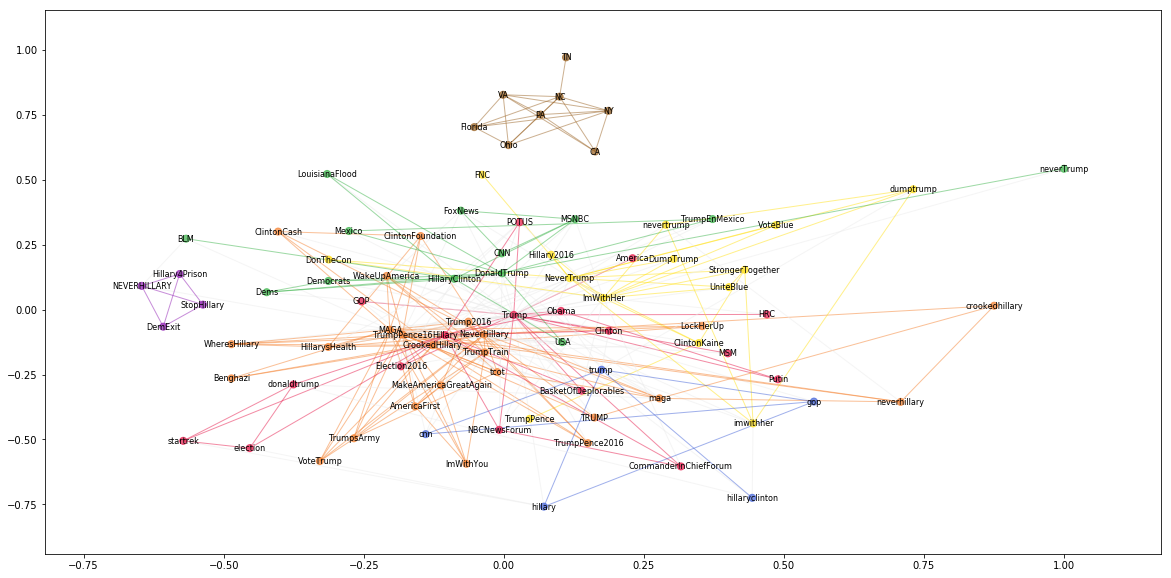

In [37]:
parts2 = community.best_partition(G2)
classes2 = [parts2.get(node) for node in G.nodes()]

edge_colors = []
for edge in G2.edges:
    (first, second) = edge
    if parts2.get(first) == parts2.get(second):
        this_class = parts2.get(first)
        # The color index is the class label
        edge_colors.append(colors[this_class])
    else:
        edge_colors.append(grey)

node_colors = [colors[parts2.get(node)] for node in G2.nodes()]

nx.draw_networkx_nodes(G2, pos=spring_pos, node_color=node_colors, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G2, pos=spring_pos, edge_color=edge_colors, alpha=0.5)
nx.draw_networkx_labels(G2, pos=spring_pos, font_size=8)

plt.savefig('filename3.png', dpi = 300)
plt.show()

# Investigating The Classes

In [38]:
for node_class in set(classes):
    print('Class #', node_class)
    for node in G.nodes():
        if node_class == parts.get(node):
            print('\t', node)
            

for node_class in set(classes):
    print('Class #', node_class)
    for node in G2.nodes():
        if node_class == parts2.get(node):
            print('\t', node)

Class # 0
	 TrumpPence
	 CrookedHillary
	 TrumpTrain
	 MakeAmericaGreatAgain
	 TRUMP
	 MAGA
	 maga
	 LockHerUp
	 NeverHillary
	 Trump2016
	 WakeUpAmerica
	 VoteTrump
	 neverhillary
	 AmericaFirst
	 HillarysHealth
	 WheresHillary
	 ImWithYou
	 TrumpPence16
	 tcot
	 TrumpsArmy
	 TrumpPence2016
	 crookedhillary
Class # 1
	 Trump
	 HillaryClinton
	 Hillary
	 MSM
	 USA
	 Clinton
	 POTUS
	 America
	 Obama
	 HRC
	 Putin
	 DonaldTrump
	 Election2016
	 CNN
	 ClintonCash
	 ClintonFoundation
	 TrumpEnMexico
	 FoxNews
	 NBCNewsForum
	 BasketOfDeplorables
	 Benghazi
	 MSNBC
	 Dems
	 Democrats
	 LouisianaFlood
	 Mexico
	 neverTrump
	 CommanderInChiefForum
	 FuckYouDonald
Class # 2
	 NeverTrump
	 ImWithHer
	 ClintonKaine
	 UniteBlue
	 DumpTrump
	 imwithher
	 DonTheCon
	 StrongerTogether
	 FNC
	 Hillary2016
	 nevertrump
	 VoteBlue
	 dumptrump
Class # 3
	 GOP
	 Hillary4Prison
	 StopHillary
	 BLM
	 DemExit
	 NEVERHILLARY
	 VOTEGOP
	 HEXIT
Class # 4
	 trump
	 hillary
	 gop
	 cnn
	 donaldtrump
	 hillarycl